# Fraud Transactions

The Bernoulli trial I want to simulate in this assignment is when a transaction occurs, the bank can treat it as either a proper transaction or a fradulent one.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

In [49]:
stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [50]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self.update_params(arm, reward)
    return reward, regret
  
  def update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

In [53]:
class ThompsonBern(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [52]:
class ThompsonNormal():
    def __init__(self, bandit):
        self.bandit = bandit
        self.transaction_count = bandit.arm_count
        self.fraud = np.ones(self.transaction_count)
        self.correct = np.ones(self.transaction_count)
        self.mu = np.ones(self.transaction_count)
        self.sigma = np.ones(self.transaction_count)
  
    def get_reward_regret(self, transaction):
        reward, regret = self.bandit.get_reward_regret(transaction)
        self.update_parameters(transaction, reward)
        return reward, regret
  
    def update_parameters(self, transaction, reward):
        self.fraud[transaction] += reward
        self.correct[transaction] += 1 - reward
        self.mu = self.fraud / (self.fraud + self.correct)
        self.sigma = (self.fraud * self.correct)/((self.fraud + self.correct)**2 * (self.fraud + self.correct +1))

    @staticmethod
    def name():
        return 'thompson normal'
  
    def get_action(self):
        theta = np.random.normal(self.mu, self.sigma)
        return theta.argmax()

In [48]:
class Random():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        
    @staticmethod
    def name():
        return 'random'
    
    def get_action(self):
        """ Generating random samples between 0 and 1 using uniform distribution"""
        theta = np.random.uniform(0,1,self.arm_count)
        return theta.argmax()
    
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

In [47]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [45]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [35]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
    
  algos = [EpsilonGreedy, UCB, ThompsonBern, Random]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

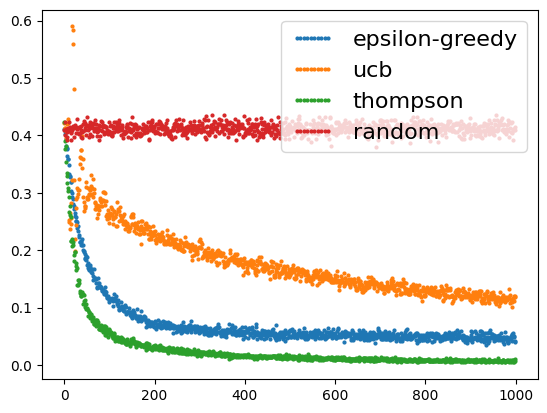

In [18]:
arm_count = 10
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

## Q.1 Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important

For Thompson Sampling, the alpha and beta from the beta distribution are important hyperparameters. However, as their values are chosen at random, we can only change the number of iterations.

For e-greedy, the value of epsilon is the hyperparameter as it determines the number of explorations.

For UCB, the value of c is the hyperparameter

Random sampling has no hyperparameter

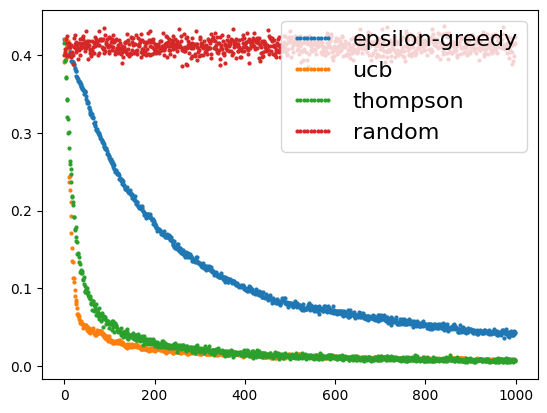

In [19]:
arm_count = 10
epsilon = 0.02
ucb_c = 0.3
stationary=True
experiment(arm_count)

## Q.2 How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why.

Lets increase number of transactions from 10 to 200

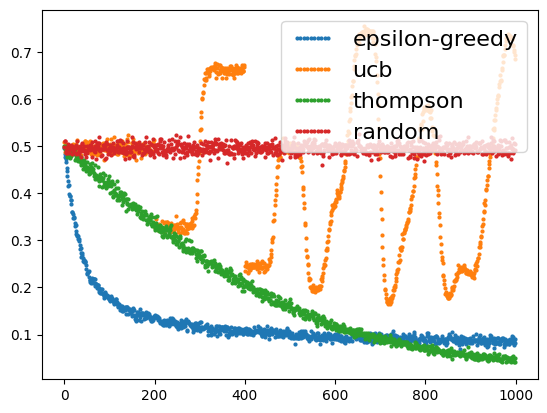

In [20]:
arm_count = 200
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

The following observations can be made from the above experiment:

E-greedy does not seem to be affected much as compared to the baseline experiment conducted above. Hence, we can conclude that the action space does not affect the e-greedy algorithm much. 

UCB seems to be very unstable, but this is not entirely because of the action space. This is also because the Bernoulli reward probabilities are really close to each other which in turn affects the regret.

The Thompson algorithm seems to be very stable when given a larger action space.

Random sampling seems to be unaffected by the change in the size of the action space.

## Q.3 How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why.

Let's set the value of stationary to False

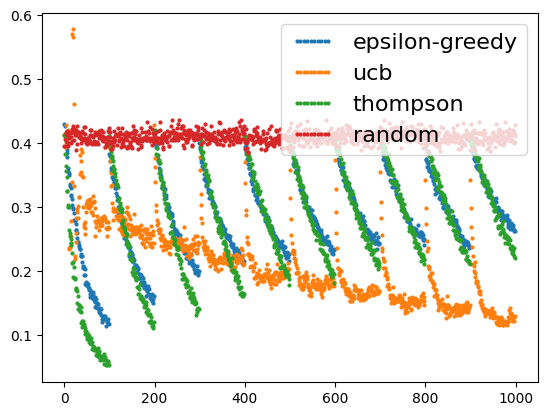

In [21]:
arm_count = 10
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

The following observations can be made from the above experiment:

UCB responds rapidly to the non-stationary affect and consistently shows improvement in regret over time maybe due to it's exploration.

E-greedy and Thompson's regret decreases quickly but it seems to increase over time.

Random sampling is not affected by a change in the stationary state.

## Q.4 When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff

Thompson sampling performs better as it efficiently explores by discarding arms with lesser long term rewards. When a very large value for aplha and beta has been selected and the random interval of each selection is very small, the exploration will eventually stop

For UCB, it picks the arm that has the maximum upper confidence bound value to balance exploration and exploitation.

For e-greedy, the epsilon needs toe be adjusted to tradeoff the exploration and exploitation.

Random sampling is always exploring

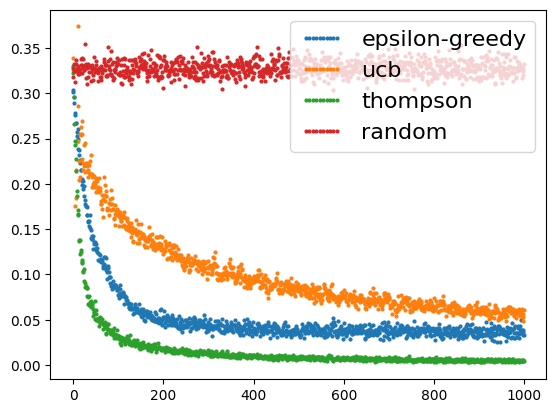

In [22]:
arm_count = 5
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

## Q.5 How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer.

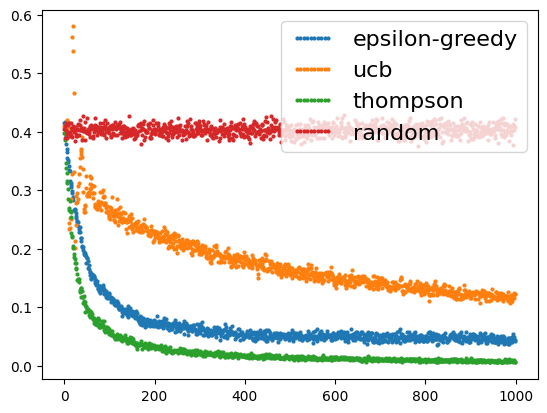

In [23]:
arm_count = 10
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

The Thompson agent reaches regret value 0 after 300 timesteps

After 400 timesteps it is difficult to see any progress in the e-greedy model as it's value is between 0.0-0.1 till the end.

UCB does not go lower than 0.1 till the end.

Random sampling remembers nothing

## Q.6 Thompson Sampling with non-Beta distribution. Modify the Thompson Sampling to run with a different distribution (normal)

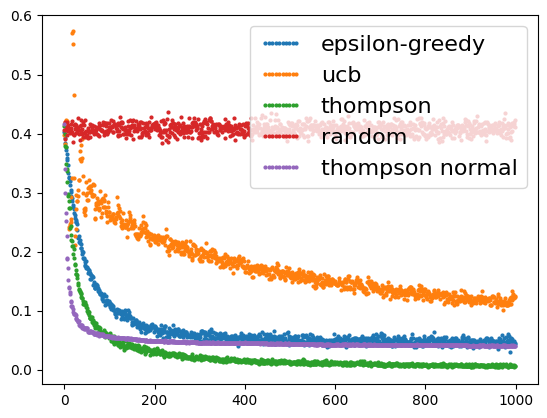

In [25]:
arm_count = 10
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

## What code is yours and what have you adapted?

I have used the following references:
#### References:
1. https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb
2. https://www.dominodatalab.com/blog/k-armed-bandit-problem
3. https://jmlr.csail.mit.edu/papers/volume7/evendar06a/evendar06a.pdf
4. https://towardsdatascience.com/thompson-sampling-fc28817eacb8
5. https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

These have been modified according to my experiments based on the topic of fraudulent transactions

## Did I explain my licensing clearly?

Copyright <2022> Jay Devnani

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.